# INF-0616 - Projeto 3: Redes neurais

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- a229999@dac.unicamp.br
           Hudson Bruno -- hudson.bruno@ic.unicamp.br 

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina: 
[moodle.lab.ic.unicamp.br](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=456)

Download do dataset: [download dataset customer-issues](https://ic.unicamp.br/~esther/customer-issues.csv)


Instituto de Computação - Unicamp 2020

Membros do grupo:
* Daniele Montenegro da Silva Barros
* Rodrigo Dantas da Silva
* Thiago Bruschi Martins


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

In [ ]:
np.random.seed(12049)

plt.rcParams['figure.figsize'] = (12, 6)

#### Lendo o conjunto de dados

O conjunto de dados consiste em reclamações de clientes a cerca de produtos/serviços oferecidos em uma instituição bancária. ***Garanta que o arquivo*** `customer-issues.csv` ***está no mesmo diretório do notebook***.

In [40]:
import pandas as pd 

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Baixando o arquivo do drive
id = '1r9cT6Q5HzJfcMA3MGIaO35tPPPgJ9Mg5'
file_name = 'customer-issues.csv'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(file_name)  


In [ ]:
d = pd.read_csv(file_name)
display(d.head())

,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634


##### Exibindo as quatro primeiras mensagens

In [ ]:
print(*d.loc[:4, 'consumer-message'], sep='\n\n')

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had b

##### Extraíndo um conjunto de testes válido

As mensagens contidas neste conjunto possuem uma relação temporal.
É importante realizar a separação dos sub-conjuntos de treino/teste respeitando esta relação, de forma a garantir que o modelo não seja treinado sobre amostras no futuro e experimentado sobre o passado.

In [ ]:
d.sort_values(by='date-received', inplace=True)

### Modelando a classificação de tópicos baseado nas mensagens de clientes

Observando no gráfico de frequências de produto sobre as conversas que este é um problema extremamente desbalanceado. Há, entretanto, amostras suficientes para a modelagem de um estimador de tópico (de produto) levando em consideração o diálogo do cliente.

In [ ]:
def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]
    
    (sns
     .barplot([l[:40] for l in labels], counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)
    
    return labels, counts

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


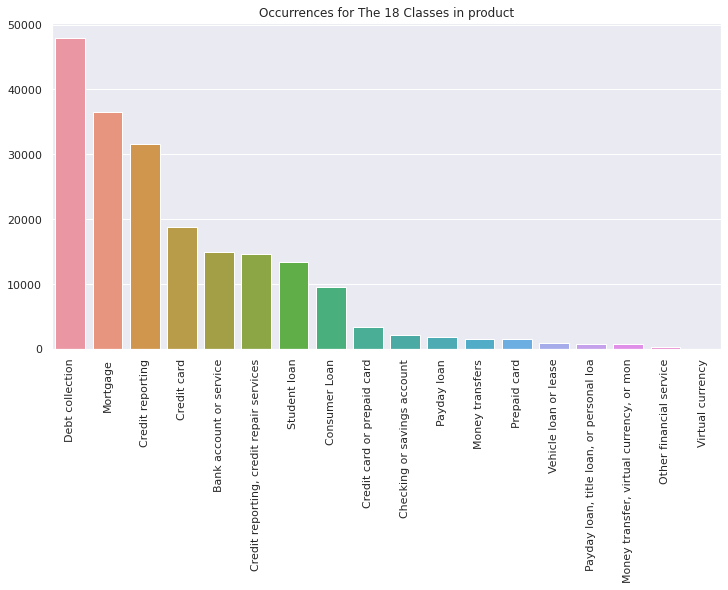

In [ ]:
labels, counamts = frequencies(d, 'product')

Simplificamos o problema, considerando somente as 6 classes mais frequentes:

In [41]:
s = d['product'].isin(labels[:6])
d = d[s]

test_share = .3

d_train, d_test = train_test_split(d, test_size=test_share, shuffle=False)
assert d_train['date-received'].max() <= d_test['date-received'].min()

x_train, x_test = d_train['consumer-message'], d_test['consumer-message']
y_train, y_test = d_train['product'], d_test['product']

Vamos codificar as palavras na conversa utilizando o TF-IDF, gerando um vetor de características baseadas nas frequências de ocorrência das palavras no documento e em todo o conjunto de dados.

In [42]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_test = label_enc.transform(y_test)

## Treinando um regressor logístico para classificar produto
**Atividade (1 pt):** treine um regressor logístico, buscando os hiper-parâmetros com *grid-search*.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_params = {'penalty':['l1','l2','elastic'],
             'C':np.logspace(-3,3, num=7),
             'class_weight':[None, 'balanced']}

clf = GridSearchCV(LogisticRegression(), lr_params, scoring='accuracy', n_jobs=-1, cv=5, verbose=2)
clf.fit(x_train, ye_train)


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 11.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2', 'elastic']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=2)

In [15]:
# Exibe o resultado do GridSearch
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)

# Salva o melhor modelo
g = clf.best_estimator_

{'C': 0.001, 'class_weight': None, 'penalty': 'l2'}
0.8237495520842746
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Iremos calcular a matriz de confusão relativa $R$, que guarda porcentagens de incidências em vez das contagens absolutas, e plotar o heatmap dessa matriz. Além disso, iremos calcular a distribuição de confiança nas predições por classe (mais próximos de `1.0` --> mais confiante):

In [16]:
def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print('Accuracy:', metrics.accuracy_score(y, p).round(3))
    print('Accuracy (balanced):', metrics.balanced_accuracy_score(y, p).round(3))
    
    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)
    
    # Impressão dos gráficos.
    (plt
     .figure(figsize=(6, 6))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)

    (plt
     .figure(figsize=(10, 10))
     .suptitle('Distribuição de confiança para cada classe', fontsize=20))
    
    

    for i in np.unique(y):
        # Para cada classe `i`, seleciona suas amostras e filtra a confiança
        # do modelo em predizer estas amostras como sendo da classe `i`.
        ax = sns.distplot(probabilities[y.ravel() == i][:, i],
                     hist=False,
                     label=labels[i])
        
        ax.legend()

Vamos utilizar a função `evaluate` para avaliar o modelo treinado anteriormente:

Accuracy: 0.757
Accuracy (balanced): 0.733


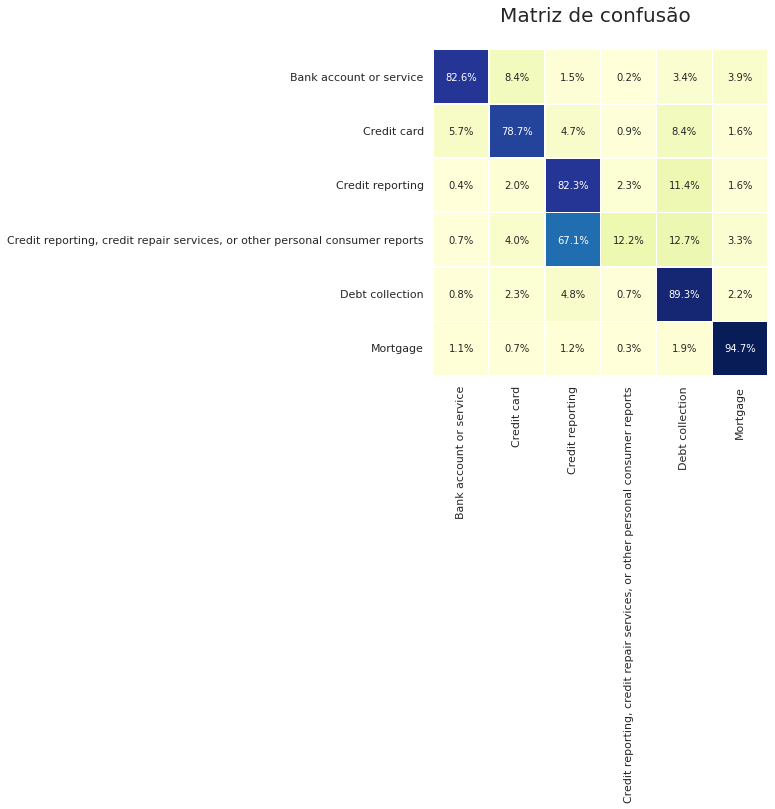

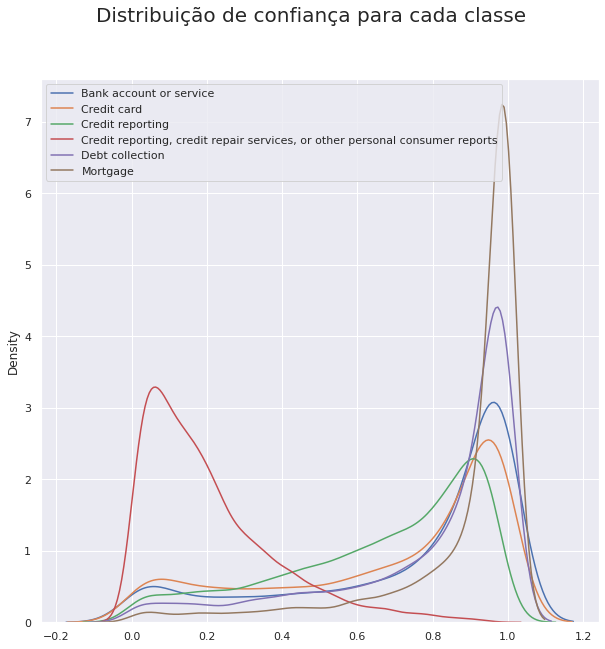

In [17]:
import warnings

# With usado apenas para ocultas as warnings que estavam sendo geradas pela funcao evaluate
# Preferimos fazer isto a alterar a funcao que nos foi fornecida
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    evaluate(ye_test, g.predict(x_test), g.predict_proba(x_test), labels=label_enc.classes_)

**Pergunta (1pt):** considerando o gráfico de distribuição de confiança para o seu modelo treinado, as amostras são classificadas com alta confiança? Há uma grande diferença de confiança entre as diferentes classes?

**Resposta**:
Considerando que o gráfico é uma distribuição de probabilidade para cada classe, podemos observar que a confiança é mais alta para as classes em que distribuição se concentra próximo ao valor 1.0. Isto significa que para estas classes a maioria das predições possuem uma confiança próxima a 100%. Podemos confirmar isso observando o matriz de confusão relativa. As duas classes com maior porcentagem de acerto são 'Mortgage' e 'Debit collection', que são justamente as duas curvas que possem maior concentração próximo a confiança de 100%. 

No entanto, há uma grande diferença na distribuição da classe 'Credit reporting, credit repair services, or other personal consumer reports' em relação ao restante das classes. Podemos ver que a curva dela apresenta um skewness positivo, isto é, a distribuição do grau de confiança desta classe se concentra muito mais próxima do 0% do que dos 100%, tendo um pico próximo aos 10%. Podemos confirmar isso observando a matriz de confusão relativa, que mostra que a taxa de acerto para esta classe é de 12.2%.

De forma geral podemos dizer que sim, há uma grande diferença de confiança entre as diferentes classes. Algumas com confiança muito alta, algumas com confiança não tão alta e uma com uma confiança muito baixa. 


----------
----------

## Redes Neurais
Iremos treinar alguns modelos de redes neurais, variando número de camadas e quantidade de neurônios em cada camada.

In [43]:
epochs = 3
batch_size = 128
input_shape = [features]

Vamos converter os rótulos em vetores *One Hot Encoded*:

In [44]:
from keras.utils import np_utils
y_ohe_train = np_utils.to_categorical(ye_train, num_classes=6)
y_ohe_test = np_utils.to_categorical(ye_test, num_classes=6)

**Atividade (1 pt):** defina uma arquitetura de uma rede neural capaz de classificar os diferentes produtos a partir da conversa dos clientes. Compile a sua rede com a loss `categorical_crossentropy`, optimizador `SGD` e defina as métricas relevantes para o problema. 

In [54]:
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Activation, Input
from keras.utils import np_utils
from tensorflow.keras import optimizers

# Definindo a arquitetura inicial da rede
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(1024,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

# Definindo o otimizador
def get_optimizer_sgd():
  return optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compilando o modelo definindo a funcao loss e as metricas relevantes
model.compile(loss='categorical_crossentropy', optimizer=get_optimizer_sgd(), metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_25 (Dense)             (None, 50)                51250     
_________________________________________________________________
dense_26 (Dense)             (None, 6)                 306       
Total params: 1,101,156
Trainable params: 1,101,156
Non-trainable params: 0
_________________________________________________________________


### Treinando a rede neural

**Atividade (1 pt):** treine o modelo definido acima sobre o conjunto, respeitando as seguintes regras:

1. Separe um subconjunto do treino para validação.
2. Utilize alguma técnica para conservar os parâmetros que melhor generalizam o problema, como `ModelCheckpoint` (salve o modelo com nome de `weights.h5`).

In [46]:
# Separando os conjuntos de treino e validacao
x_train, x_val, y_ohe_train, ye_val = train_test_split(x_train, y_ohe_train, test_size=0.25, random_state=1)

# Lidando com o problema da matriz esparsa
x_train = x_train.toarray()
x_val = x_val.toarray()
x_test = x_test.toarray()

In [55]:
# Callback para a criacao do checkpoint
from keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath="weights.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


# Treinamento
epochs = 10
batch_size = 128

history = model.fit(
      x_train, 
      y_ohe_train,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      callbacks=[model_checkpoint_callback],
      validation_data=(x_val, ye_val),
    )

model.save('primeira_rede.h5')

Epoch 1/10
675/675 [==============================] - 14s 20ms/step - loss: 0.6026 - accuracy: 0.7941 - val_loss: 0.5235 - val_accuracy: 0.8239
Epoch 2/10
675/675 [==============================] - 13s 20ms/step - loss: 0.4033 - accuracy: 0.8637 - val_loss: 0.5042 - val_accuracy: 0.8333
Epoch 3/10
675/675 [==============================] - 13s 20ms/step - loss: 0.2957 - accuracy: 0.9008 - val_loss: 0.5143 - val_accuracy: 0.8359
Epoch 4/10
675/675 [==============================] - 13s 20ms/step - loss: 0.1903 - accuracy: 0.9384 - val_loss: 0.5624 - val_accuracy: 0.8377
Epoch 5/10
675/675 [==============================] - 13s 20ms/step - loss: 0.1065 - accuracy: 0.9697 - val_loss: 0.6314 - val_accuracy: 0.8426
Epoch 6/10
675/675 [==============================] - 13s 20ms/step - loss: 0.0609 - accuracy: 0.9846 - val_loss: 0.6788 - val_accuracy: 0.8438
Epoch 7/10
675/675 [==============================] - 13s 20ms/step - loss: 0.0378 - accuracy: 0.9917 - val_loss: 0.7359 - val_accuracy:

O método `model.fit` retorna `model.history`, e contem algumas informações interessantes a respeito do histórico de treinamento.

**Atividade (1 pt):** plote um gráfico de linhas exibindo a evolução dos valores da função *loss* sobre o conjunto de treino e validação. A partir de qual `epoch` a rede começou a super-especializar?


**Resposta:** Observando o gráfico vemos que a nossa rede começa a se super-espelizalizar na época 3, pois é quando o valor da Loss de Validação começa a subir. Podemos ver também que a Loss no treino é cada vez menor, o que indica que a rede está se especializando nos dados do treino e não está conseguindo aprender (generalizar).

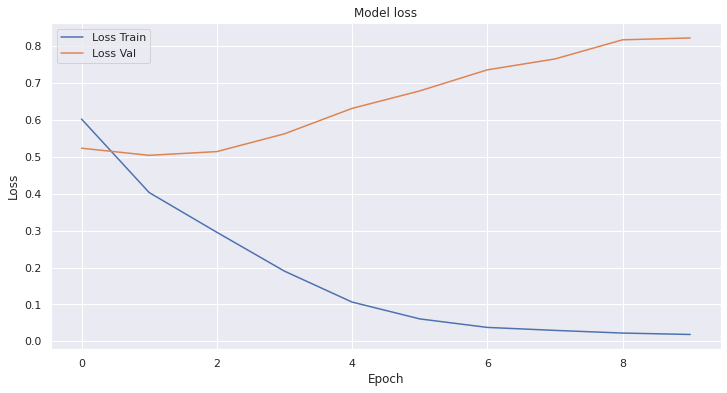

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss Train', 'Loss Val'], loc='upper left')
plt.show()

### Avaliando o modelo treinado

**Atividade (1 pt):** teste o modelo treinado utilizando o subconjunto de teste. Reporte a acurácia para cada classe e a matriz de confusão percentual (usando a função `evaluate` definida anteriormente).

Accuracy: 0.746
Accuracy (balanced): 0.724


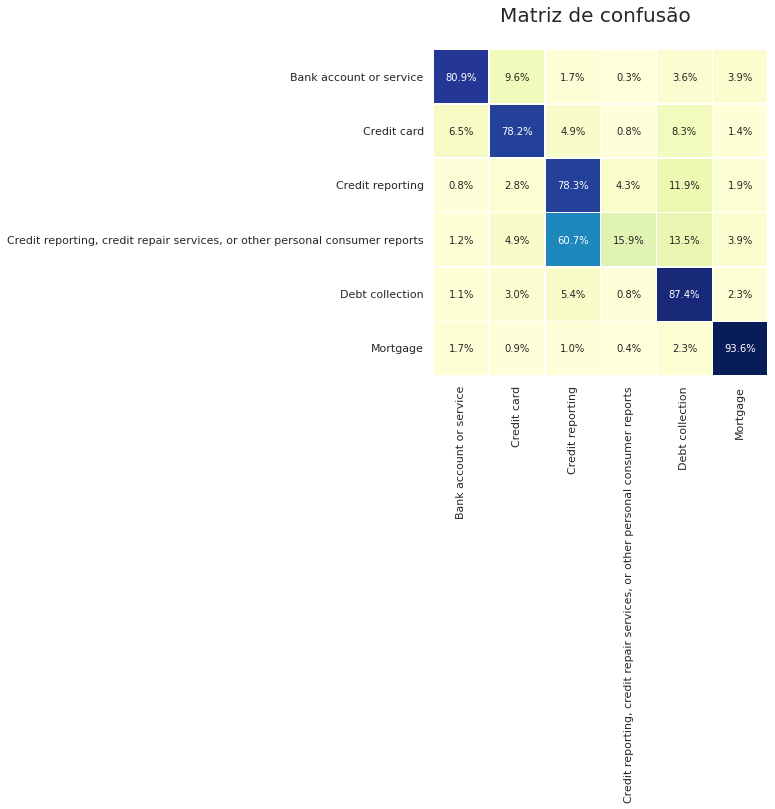

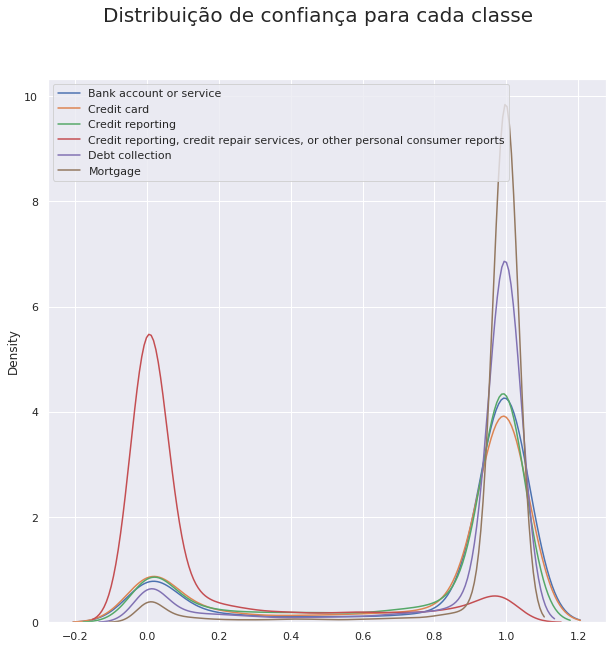

In [142]:
prob_test = model.predict(x_test)
pred_test = [np.argmax(p) for p in prob_test]

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    evaluate(ye_test, pred_test, prob_test, labels=label_enc.classes_)

--------
## Nova Rede (mais profunda)
Repita agora a definição, treinamento e avaliação de uma rede neural mais complexa, aumentando o número de camadas ou a quantidade de neurônios nas camadas da rede anterior:

**Atividade (1 pt):** defina uma rede neural mais complexa e a compile com as mesmas configurações da rede anterior.

In [63]:
# Definindo a arquitetura da rede mais complexa
model2 = Sequential()
model2.add(Dense(1024, activation='relu', input_shape=(1024,)))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(6, activation='softmax'))
model2.summary()

# Definindo o otimizador
def get_optimizer_sgd():
  return optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compilando o modelo definindo a funcao loss e as metricas relevantes
model2.compile(loss='categorical_crossentropy', optimizer=get_optimizer_sgd(), metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_28 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_29 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_30 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_33 (Dense)             (None, 16)               

**Atividade (1 pt):** treine a nova rede.

In [64]:
# Treinamento
epochs = 10
batch_size = 128

history = model2.fit(
      x_train, 
      y_ohe_train,
      batch_size=batch_size,
      epochs=epochs,
      verbose=0,
      callbacks=[model_checkpoint_callback],
      validation_data=(x_val, ye_val),
    )

model2.save('segunda_rede.h5')

Epoch 1/10
675/675 [==============================] - 25s 36ms/step - loss: 0.6889 - accuracy: 0.7577 - val_loss: 0.5500 - val_accuracy: 0.8153
Epoch 2/10
675/675 [==============================] - 24s 35ms/step - loss: 0.4186 - accuracy: 0.8596 - val_loss: 0.5157 - val_accuracy: 0.8317
Epoch 3/10
675/675 [==============================] - 24s 35ms/step - loss: 0.2967 - accuracy: 0.9017 - val_loss: 0.5283 - val_accuracy: 0.8371
Epoch 4/10
675/675 [==============================] - 23s 35ms/step - loss: 0.1842 - accuracy: 0.9398 - val_loss: 0.5990 - val_accuracy: 0.8284
Epoch 5/10
675/675 [==============================] - 23s 35ms/step - loss: 0.1190 - accuracy: 0.9613 - val_loss: 0.6874 - val_accuracy: 0.8344
Epoch 6/10
675/675 [==============================] - 23s 34ms/step - loss: 0.0893 - accuracy: 0.9710 - val_loss: 0.7832 - val_accuracy: 0.8295
Epoch 7/10
675/675 [==============================] - 23s 35ms/step - loss: 0.0735 - accuracy: 0.9755 - val_loss: 0.7873 - val_accuracy:

## Nova Rede com Regularização
**Atividade (1 pt):** adicione dropout ou regularização L1/L2 e treine o novo modelo. Se for, preciso, faça uma busca pelos hipeparâmetros da regularização/dropout.

In [150]:
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# Funcao que cria uma nova reda para cada novo valor de dropout
def new_NN(drop_rate):
  m = Sequential()
  m.add(Dense(1024, activation='relu', input_shape=(1024,)))
  m.add(Dropout(drop_rate))
  m.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
  m.add(Dense(256, activation='relu'))
  m.add(Dropout(drop_rate))
  m.add(Dense(128, activation='relu'))
  m.add(Dense(64, activation='relu'))
  m.add(Dropout(drop_rate))
  m.add(Dense(32, activation='relu'))
  m.add(Dense(16, activation='relu'))
  m.add(Dense(6, activation='softmax'))

  m.compile(loss='categorical_crossentropy', optimizer=get_optimizer_sgd(), metrics=['accuracy'])
  return m

drop_rate = np.linspace(0,0.5,6)
drop_results = pd.DataFrame({'Dropout':[], 'Score':[]})
epochs=5

# Busca pelo valor de dropout que traz o melhor resultado
for dropout in drop_rate:
  new_model = new_NN(dropout)
  new_model.fit(
      x_train, 
      y_ohe_train,
      batch_size=batch_size,
      epochs=epochs,
      verbose=0,
      callbacks=[model_checkpoint_callback],
      validation_data=(x_val, ye_val),
    )
  
  prob = new_model.predict(x_val)
  pred = [np.argmax(p) for p in prob]

  # Salva a acuracia na validacao
  score = new_model.evaluate(x_val, ye_val)[1]
  drop_results = drop_results.append({'Dropout':dropout, 'Score':score}, ignore_index=True)

drop_results.sort_values('Score')

900/900 [==============================] - 4s 5ms/step - loss: 0.5484 - accuracy: 0.8210


,Dropout,Score
5,0.5,0.820955
4,0.4,0.825783
3,0.3,0.825853
2,0.2,0.830022
0,0.0,0.831515
1,0.1,0.840200


In [164]:
# Treina o melhor modelo da regularizacao
model3 = new_NN(0.1)

model3.fit(
      x_train, 
      y_ohe_train,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      callbacks=[model_checkpoint_callback],
      validation_data=(x_val, ye_val),
    )

model3.save('terceora_rede.h5')

## Avaliação Final
**Atividade (1 pt):** avalie os modelos treinados e compare com os resultados anteriores.

### Rede Profunda

Accuracy: 0.733
Accuracy (balanced): 0.714


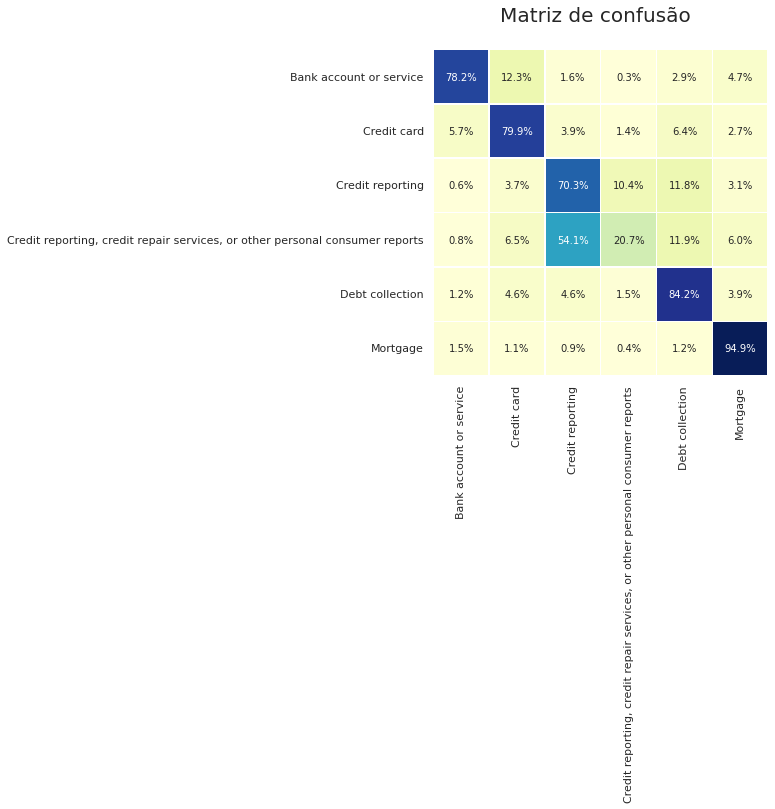

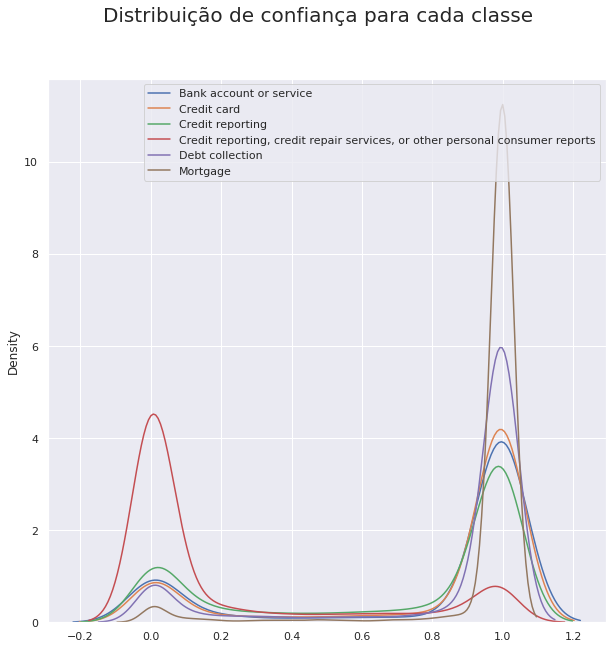

In [74]:
prob_test2 = model2.predict(x_test)
pred_test2 = [np.argmax(p) for p in prob_test2]

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    evaluate(ye_test, pred_test2, prob_test2, labels=label_enc.classes_)

### Rede profunda com Regularização

Accuracy: 0.742
Accuracy (balanced): 0.721


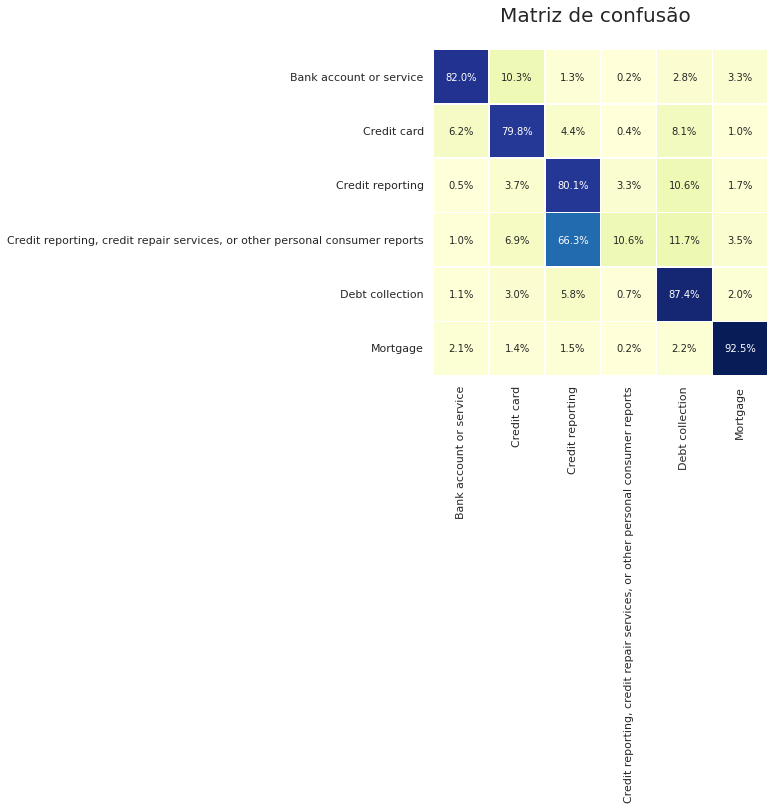

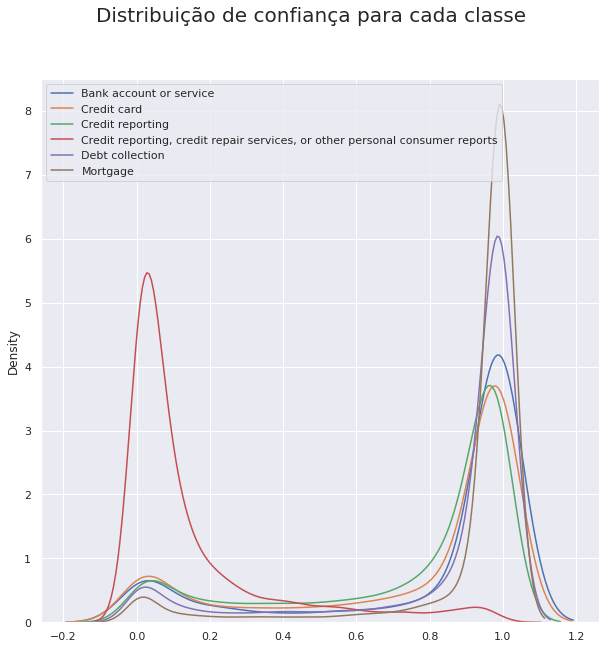

In [155]:
prob_test3 = model3.predict(x_test)
pred_test3 = [np.argmax(p) for p in prob_test3]

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    evaluate(ye_test, pred_test3, prob_test3, labels=label_enc.classes_)

### Comparando os resultados

In [166]:
resultados = pd.DataFrame({'Modelo':['Logistic Regression','Rede inicial', 'Rede Profunda', 'Rede Profunda com Dropout'],
                           'Acuracia':[0.757, 0.746, 0.733, 0.742],
                           'Acuracia Balanceada':[0.733, 0.724, 0.714, 0.721]})

resultados.sort_values('Acuracia Balanceada', ascending=False)

,Modelo,Acuracia,Acuracia Balanceada
0,Logistic Regression,0.757,0.733
1,Rede inicial,0.746,0.724
3,Rede Profunda com Dropout,0.742,0.721
2,Rede Profunda,0.733,0.714


**Conclusão**

A tabela anterior apresenta o resultado dos 4 melhores modelos treinados. O Logistic Regression obteve o melhor resultado nas duas métricas escolhidas: Acurácia e Acurácia Balanceada. No entanto, ao comparmos os gráficos podemos dizer que a Rede Inicial possui mais confiança nos resultados, pois o gráfico de densidade dela mostra-se mais concentrado próximo a confiança de 100%, isto é, com skewness mais positivo e uma curtose maior do que a do modelo de regressão logística. Já entre as redes neurais, a Rede Inicial obteve o melhor resultado, o que nos dá indícios de que para melhorar o resultado neste problema em específico, deveríamos explorar uma rede com menos camadas. Mas, caso optássemos por ir adiante com redes mais profundas, deveríamos continuar explorando os parâmetros de regularização, pois, a rede profunda com dropout mostrou ser melhor do que sem. 

Neste trabalho exploramos quatro parâmetros (ou características) de redes neurais: número de épocas, número de neurônios, número de camadas e regularização. Nessas quatro análises observamos que não adianta apenas aumentar o valor dos parâmetros, pois, se não forem corretamente ajustados todos eles podem apresentar efeitos negativos ao modelo (seja Overfitting ou Underfitting, no caso da regularização). Por isso, para encontrar o valor ótimo de cada uma dessas características seria necessário um estudo mais aprofundado, pois, neste relatório nos limitamos a fazer apenas o que foi pedido, para fins de comparação. Vale lembrar ainda que mesmo neste tipo de rede ainda houve pelo menos dois parâmetros que não variamos: batch_size e otimizador. Juntanto tudo isso com o resultado da tabela anterior, podemos dizer que para se utilizar uma rede neural é necessário muito estudo sobre os parâmetros da rede, caso não haja todo esse tempo ou disposição disponível, é melhor utilizar modelos mais simples como o Logistic Regression, que obteve o melhor resultado deste relatório.